In [1]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-
import random
import copy
import re
import sys
import numpy as np
import os
import time
import pandas as pd
import csv
import matplotlib
import matplotlib.pyplot as plt
from tkinter import *
from tkinter.ttk import *
# try:
#     from tkinter import *
#     from tkinter.ttk import *
# except Exception as e:
#     print("[ERROR]: {0}".format(e))
#     from tkinter import *

# Генетический алгоритм 

In [2]:
list_of_cities = []
# Вероятность мутации данного маршрута
# k_mut_prob = float(input('Введите вероятность мутации, вещественное число между 0 и 1: '))
k_mut_prob = 0.744932080
# Число поколений
# k_n_generations = int(input('Введите число поколений, целое число (100, ..): '))
k_n_generations = 419
# Размер популяции (RoutePop)
# k_population_size = int(input('Введите размер популяции, целое число (50,  ..): '))
k_population_size = 238
# Размер отбора
# tournament_size = int(input('Введите размер отбора, целое число (25, ..): '))
tournament_size = 76

# Если elitism есть True, то лучшее из одного поколения будет передано следующему
elitism = True
# Считывать информацию из csv?
csv_cities = False

## Класс City

In [3]:
class City(object):
    """
    Здесь лежат объекты класса City. При инициализации автоматически добавляются в list_of_cities

    self.x: x-координата
    self.y: y-координата
    self.name
    self.distance_to: словарь расстояний к другим городам (ключи - имя города, значения - вещественны)
    """
    def __init__(self, name, x, y, distance_to=None):
        # Имя и координаты:
        self.name = name
        self.x = self.graph_x = x
        self.y = self.graph_y = y
        # Добавляет себя в глобальный список городов list_of_cities:
        list_of_cities.append(self)
        # Создается словарь расстояний ко всем остальным городам
        self.distance_to = {self.name: 0.0}
        if distance_to:
            self.distance_to = distance_to

    def calculate_distances(self):
        """
        self --> None
        Считает расстояния от данного города
        ко всем остальным в глобальном списке list_of_cities,
        а затем кладет эти значения в словарь self.distance_to,
        где ключ - имя города, значения - вещественные числа
        """
        for city in list_of_cities:
            tmp_dist = self.point_dist(self.x, self.y, city.x, city.y)
            self.distance_to[city.name] = tmp_dist

    # Вычисление расстояния между двумя точками
    def point_dist(self, x1, y1, x2, y2):
        return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5

## Класс Route

In [4]:
class Route(object):
    """
    Содержит упорядоченный список всех объектов класса City в глобальной переменной list_of_cities.
    Также хранит информацию о пути (= маршруте = туре)

    self.route: список городов в list_of_cities. Произвольно перемешивается при __init__
    self.length: (вещественная) длина пути (цикл - full loop)
    self.is_valid_route(): возвращает True, если маршрут содержит все города из list_of_cities только единожды,
    без повторных прохождений
    self.pr_cits_in_rt(): выводит все города маршрута в форме <cityname1, cityname2, cityname3...>
    self.pr_vrb_cits_in_rt: выводит координаты городов из тура в формате <|x,y|x,y|x,y|...>
    """
    def __init__(self):
        # Создаем маршрут, равный случайному перемешиванию list_of_cities
        self.route = sorted(list_of_cities, key=lambda *args: random.random())
        # Считаем его длину
        self.recalc_rt_len()

    def recalc_rt_len(self):
        """
        self --> None
        Метод для пересчитывания длины пути в случае, если
        аттрибут self.route поменяли вручную
        """
        # Зануляем длину
        self.length = 0.0
        # Для каждого города из маршрута:
        for city in self.route:
            next_city = self.route[self.route.index(city) - len(self.route) + 1]
            # Расстояние до следующего города
            dist_to_next = city.distance_to[next_city.name]
            # Добавляем эту длину в атрибут длины
            self.length += dist_to_next

    def pr_cits_in_rt(self, print_route=False):
        """
        self --> None
        Выводит все города маршрута в формате <cityname1, cityname2, cityname3...>
        """
        cities_str = ''
        for city in self.route:
            cities_str += city.name + ', '
        if print_route:
            print(cities_str)

    def is_valid_route(self):
        """
        self --> Bool()
        Возвращает True, если маршрут содержит все города в list_of_cities лишь единожды,
        иначе False (то есть если есть дупликаты)

        Зачем? Если в маршруте несколько экземпляров данного города, то
        алгоритм сойдется, когда все города отождествятся с данным (length = 0)
        """

        for city in list_of_cities:
            # Вспомогательная функция
            if self.count_mult(self.route, lambda c: c.name == city.name) > 1:
                return False
        return True

    # Проврка на дупликаты
    def count_mult(self, seq, pred):
        return sum(1 for v in seq if pred(v))

## Содержит популяцию объектов класса Route()

In [5]:
class RoutePop(object):
    """
    Содержит список объектов класса Route() и информацию и о них

    self.rt_pop: список объектов Route()
    self.size: длина rt_pop - уточняется при __init__
    self.fittest: объект Route()с кратчайшем длиной из self.rt_pop
        Фитнес: функция, которая говорит нам, насколько хорош каждый маршрут (в нашем случае, насколько
        короткое расстояние)
    self.get_fittest(): Вычисляет fittest маршрут, задает ему self.fittest и возвращает Route.
    Используется, если маршруты были вручную изменены
    """
    def __init__(self, size, initialise):
        self.rt_pop = []
        self.size = size
        # Если хотим инициализировать population.rt_pop:
        if initialise:
            for x in range(0,size):
                new_rt = Route()
                self.rt_pop.append(new_rt)
            self.get_fittest()

    def get_fittest(self):
        """
        self --> Route()
        Возвращает два кратчайших пути из популяции, список self.top_two
        """
        # Сортирует список по длине маршрута
        sorted_list = sorted(self.rt_pop, key=lambda x: x.length, reverse=False)
        self.fittest = sorted_list[0]
        return self.fittest

## Класс для соединения всех методов генетического алгоритма (GA) воедино

In [6]:
class GA(object):
    """
    Класс для запуска генетического алгоритма. Не объявляем __init__ - класс всего лишь
    предоставляет методы.
    crossover(parent1, parent2): Возвращает маршрут-ребенка после скрещивания двух родительских маршрутов
    """
    def crossover_experimental(routeA, routeB):
        """Алгоритм экспериментального кроссинговера"""
        # Новый ребенок Route()
        child_rt = Route()

        # Защищает от повторного вычисления
        routeB_len = len(routeB.route)

        # Выбор рандомного города
        random_city = random.choice(list_of_cities)

        # routeA going down
        # routeB going up

        incrementing_a = True
        incrementing_b = True

        idx_a = routeA.route.index(random_city)
        idx_b = routeB.route.index(random_city)

        idx_a -= 1
        idx_b += 1

        if idx_a < 0:
            incrementing_a = False

        if idx_b >= routeB_len:
            incrementing_b = False

        child_rt.route = [random_city]

        while (incrementing_a and incrementing_b):
            if idx_a >= 0:
                if not (routeA.route[idx_a] in child_rt.route):
                    child_rt.route.insert(0, routeA.route[idx_a])
            idx_a -= 1

            if idx_a < 0:
                incrementing_a = False
                break

            if idx_b < routeB_len:
                if not (routeB.route[idx_b] in child_rt.route):
                    child_rt.route.append(routeB.route[idx_b])

            idx_b += 1

            if idx_b >= routeB_len:
                incrementing_b = False
                break

        # Теперь либо incrementing_a, либо incrementing_b должны быть False
        shuffled_cities = sorted(routeA.route, key=lambda *args: random.random())
        for city in shuffled_cities:
            if city not in child_rt.route:
                child_rt.route.append(city)

        return child_rt

    def crossover(self, parent1, parent2):
        """Route(), Route() --> Route()

        Возвращает маршрут-ребенка Route() после скрещивания двух родительских маршрутов
        Маршруты должны быть одной длины

        Скрещивание производится выбором рандомного диапозона parent1 и располагая его в пустой маршрут-ребенка
        (на то же место). Пробелы заполняются без дупликатов, в том порядке, в котором они появляются в parent2

        Пример:
            parent1: 0123456789
            parent1: 5487961320

            start_pos = 0
            end_pos = 4

            незаполненный ребенок: 01234*****
            заполненный ребенок: 0123458796
        """

        # new child Route()
        child_rt = Route()

        for x in range(0,len(child_rt.route)):
            child_rt.route[x] = None

        # Два рандомных целых индекса parent1
        start_pos = random.randint(0, len(parent1.route))
        end_pos = random.randint(0, len(parent1.route))

        # Берет подмаршрут родителя и вставляет в себя
        if start_pos < end_pos:
            # do it in the start-->end order
            for x in range(start_pos,end_pos):
                child_rt.route[x] = parent1.route[x]
        elif start_pos > end_pos:
            for i in range(end_pos,start_pos):
                child_rt.route[i] = parent1.route[i]

        # Теперь по второму родителю parent2. Заполняем ребенка child_rt
        for i in range(len(parent2.route)):
            # Если у родителя parent2 есть город, к-го нет в ребенке,
            if not parent2.route[i] in child_rt.route:
                # то вставляет его в первую None ячейку и выходит из цикла
                for x in range(len(child_rt.route)):
                    if child_rt.route[x] == None:
                        child_rt.route[x] = parent2.route[i]
                        break
        # Повторяем до тех пор, пока не заполним ребенка 

        # Возвращаем маршрут-ребенка (child_route)
        child_rt.recalc_rt_len()
        return child_rt

    def mutate(self, route_to_mut):
        """
        Route() --> Route()
        Меняет два рандомных индекса в route_to_mut.route
        """
        if random.random() < k_mut_prob:
            # 2 рандомных индекса:
            mut_pos1 = random.randint(0, len(route_to_mut.route) - 1)
            mut_pos2 = random.randint(0, len(route_to_mut.route) - 1)
            if mut_pos1 == mut_pos2:
                return route_to_mut
            city1 = route_to_mut.route[mut_pos1]
            city2 = route_to_mut.route[mut_pos2]
            route_to_mut.route[mut_pos2] = city1
            route_to_mut.route[mut_pos1] = city2

        # Пересчитываем длину маршрута
        route_to_mut.recalc_rt_len()
        return route_to_mut

    def mutate_2opt(route_to_mut):
        if random.random() < k_mut_prob:
            for i in range(len(route_to_mut.route)):
                for ii in range(len(route_to_mut.route)): # i = a, i + 1 = b, ii = c, ii+1 = d
                    if (route_to_mut.route[i].distance_to[route_to_mut.route[i-len(route_to_mut.route)+1].name]
                     + route_to_mut.route[ii].distance_to[route_to_mut.route[ii-len(route_to_mut.route)+1].name]
                     > route_to_mut.route[i].distance_to[route_to_mut.route[ii].name]
                     + route_to_mut.route[i-len(route_to_mut.route)+1].distance_to[route_to_mut.route[ii-len(route_to_mut.route)+1].name]):

                        c_to_swap = route_to_mut.route[ii]
                        b_to_swap = route_to_mut.route[i-len(route_to_mut.route)+1]

                        route_to_mut.route[i-len(route_to_mut.route)+1] = c_to_swap
                        route_to_mut.route[ii] = b_to_swap
            route_to_mut.recalc_rt_len()
        return route_to_mut

    def tournament_select(self, population):
        """
        RoutePop() --> Route()
        Рандомно выбирается размер отбора среди маршрутов из исходной популяции
        Выбирает наиболее подходящий
        Принцип действия: дается шанс плохим маршрутам на успех в дальнейшем, но в приоритете хорошие маршруты
        """

        # Новая популяция поменьше
        tournament_pop = RoutePop(size=tournament_size, initialise=False)
        for i in range(tournament_size-1):
            tournament_pop.rt_pop.append(random.choice(population.rt_pop))
        return tournament_pop.get_fittest()

    def evolve_population(self, init_pop):
        """RoutePop() --> RoutePop()
        Берет популяцию и происходится эволюция с дальнейшим возвращением новой популяции
        """
        # Создаем новую популяцию
        descendant_pop = RoutePop(size=init_pop.size, initialise=True)

        # elitism_offset - кол-во маршрутов, передаваемых новому поколению
        elitismOffset = 0
        if elitism:
            descendant_pop.rt_pop[0] = init_pop.fittest
            elitismOffset = 1

        # Проходится по новой популяции и заполняет ее ребенком двух
        # родителей-победителей из отбора в предыдущей популяции
        for x in range(elitismOffset,descendant_pop.size):
            tournament_parent1 = self.tournament_select(init_pop)
            tournament_parent2 = self.tournament_select(init_pop)
            tournament_child = self.crossover(tournament_parent1, tournament_parent2)
            # Заполняем популяцию ребенком
            descendant_pop.rt_pop[x] = tournament_child

        # Мутация маршрутов
        for route in descendant_pop.rt_pop:
            if random.random() < 0.3:
                self.mutate(route)

        # Обновление лучшего маршрута:
        descendant_pop.get_fittest()

        return descendant_pop

In [23]:
class App(object):
    def __init__(self, n_generations, pop_size, graph=False):
        """Инициализация объекта класса App для запуска на поколениях
        с популяцией размера pop_size"""
        if csv_cities:
            self.read_csv()

        self.n_generations = n_generations
        self.pop_size = pop_size

        print("Вычисление цикла GA..")
        self.GA_loop(n_generations, pop_size, graph=graph)

    def read_csv(self):
        with open(csv_name, 'rt') as f:
            reader = csv.reader(f)
            for row in reader:
                City(row[0], float(row[1]), float(row[2]))

    def GA_loop(self, n_generations, pop_size, graph=True):
        best_routes_to_print, num_of_generations, true_opt_min = [], [], []
        # Отсчет времени
        start_time = time.time()
        
        # Создание популяции
        print("Создание популяции..")
        the_population = RoutePop(pop_size, True)
        print("Создание популяции завершено")

        # Удостоверяемся, что нет дубликатов одного и того же города
        if not the_population.fittest.is_valid_route():
            raise NameError('Найдены идентичные города. Проверьте правильность введенных данных.')
            return

        # Лучшая длина маршрута из первой популяции
        initial_length = the_population.fittest.length

        # Создается рандомный маршрут - best_route, в нем будет результат, кратчайший путь
        best_route = Route()

        # В течение (number of generations) раз проходимся циклом по GA
        
#       Тут цикл со Скользящим Средним
#         for x in range(1, n_generation):
        for x in range(15):
            # Эволюционирование популяции:
            the_population = GA().evolve_population(the_population)

            # Найдя более краткий маршрут, сохраняем его в best_route
            if the_population.fittest.length < best_route.length:
                best_route = copy.deepcopy(the_population.fittest)

            num_of_generations.append(x)
            best_routes_to_print.append(the_population.fittest.length)
            true_opt_min.append(1473)

            # Выводим инфу в терминал
            self.clear_term()
            if x % 25 == 0:
                print('Поколение {0}:'.format(x))
                print('Длина текущего кратчайшего пути {0:.2f}'.format(the_population.fittest.length))
        n = 10
        i = 2
        eps = 1e-1
        B=[]
        B.append(np.mean(pd.Series(best_routes_to_print).rolling(window=n).mean().iloc[n-1:].values)+5)
        B.append(np.mean(pd.Series(best_routes_to_print).rolling(window=n).mean().iloc[n-1:].values))
        while B[i-2] - B[i-1] >= eps:
            i += 1
            # Эволюционирование популяции:
            the_population = GA().evolve_population(the_population)

            # Найдя более краткий маршрут, сохраняем его в best_route
            if the_population.fittest.length < best_route.length:
                best_route = copy.deepcopy(the_population.fittest)

            num_of_generations.append(i + 12)
            best_routes_to_print.append(the_population.fittest.length)
            true_opt_min.append(1473)

            # Выводим инфу в терминал
            self.clear_term()
            B.append(np.mean(pd.Series(best_routes_to_print).rolling(window=n).mean().iloc[n-1:].values))
            if i % 75 == 0:
                print('Поколение {0}:'.format(i + 12))
                print(B[i-2] - B[i-1])
                print('Длина текущего кратчайшего пути {0:.2f}'.format(the_population.fittest.length))
        plt.figure(figsize=(10, 7), dpi=70)
        plt.plot(num_of_generations, best_routes_to_print, 'aqua', label='Сходимость генетического алгоритма')
        plt.plot(num_of_generations, true_opt_min, 'pink', label='Оптимальное решение')
        plt.xlabel('Число поколений')
        plt.ylabel('Длина маршрута')
        plt.title('Генетический алгоритм')
        plt.legend()

        # Фиксируем затраченное время
        end_time = time.time()
    
        # Выводим результаты в терминал
        self.clear_term()
        print('Завершение эволюции поколений в кол-ве {0}.'.format(len(num_of_generations)))
        print("Затраченное время: {0:.1f} секунд.".format(end_time - start_time))
        print(' ')
        print('Изначальная длина маршрута: {0:.2f}'.format(initial_length))
        print('Итоговый кратчайший маршрут: {0:.2f},'.format(best_route.length))
#         print('проходящий через города:', best_route.pr_cits_in_rt(print_route=True))

    # Вспомогательная функция для clearing terminal window
    def clear_term(self):
        os.system('cls' if os.name == 'nt' else 'clear')

In [8]:
try:
    start_time = time.time()
#     f = open("/Users/ian/Documents/GitHub/TSP/3_matrix.in", "r") # 3 города
#     f = open("/Users/ian/Documents/GitHub/TSP/29_matrix.in", "r") # 29 городов
#     f = open("/Users/ian/Documents/GitHub/TSP/br17.in", "r") # 17 городов - 39
#     f = open("/Users/ian/Documents/GitHub/TSP/ft53_22.in", "r") # 53 города - 6905
    f = open("/Users/ian/Documents/GitHub/TSP/ftv35.in", "r") # 36 городов - 1473
#     f = open("/Users/ian/Documents/GitHub/TSP/ry48p.in", "r") # 48 городов - 14422
#     f = open("/Users/ian/Documents/GitHub/TSP/assymetric_matrix.in", "r") # 1000 городов
    lines = int(f.readline())
    for i, li in enumerate(f.readlines(), start=1):
        os.system('cls' if os.name == 'nt' else 'clear')
        d = {}
        for j, line in enumerate(map(float, li.split()), start=1):
            d[str(j)] = line
        City(str(i), 10, 10, d)
    band = True
except Exception as e:
    print(e)
    band = False

В поиске кратчайшего возможного пути...
Вычисление цикла GA..
Создание популяции..
Создание популяции завершено
Поколение 0:
Длина текущего кратчайшего пути 3673.00
Поколение 87:
1.5463648166182793
Длина текущего кратчайшего пути 1979.00
Поколение 162:
0.5869493251846052
Длина текущего кратчайшего пути 1933.00
Поколение 237:
0.26487589059979655
Длина текущего кратчайшего пути 1933.00
Поколение 312:
0.1501400468994234
Длина текущего кратчайшего пути 1933.00
Завершение эволюции поколений в кол-ве 382.
Затраченное время: 25.3 секунд.
 
Изначальная длина маршрута: 4052.00
Итоговый кратчайший маршрут: 1933.00,


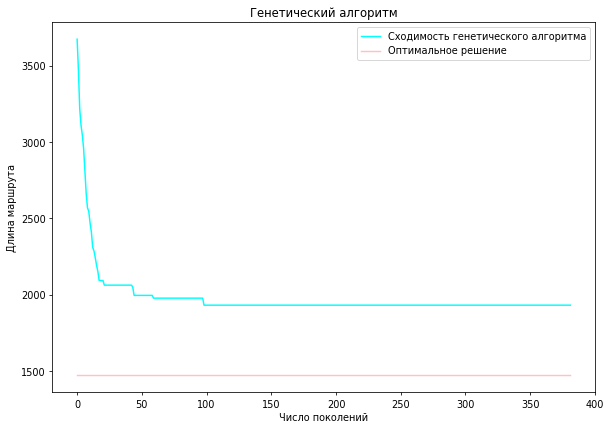

In [25]:
if band:
    print("В поиске кратчайшего возможного пути...")
    try:
        start_time = time.time()
        App(n_generations=k_n_generations, pop_size=k_population_size)
    except Exception as e:
        print("\n[ERROR]: %s\n" % e)

# Метод ветвей и границ

In [16]:
def readmx(file):
    rf = open(file, 'r')
    A = []
    mxstr = []
    fl = False
    n = 0
    for l_n, line in enumerate(rf):
        if 'DIMENSION:' in line:
            n = int(re.findall(r'\d+', line)[0])
        if 'EOF' in line:
            fl = False
        restr = []
        if fl:
            nst = re.findall(r'\d+', line)
            sdl = list(map(int, nst))
            restr = sdl[n - len(mxstr):len(sdl)]
            mxstr+=sdl[0:n-len(mxstr)]
        if len(mxstr) == n and n != 0:
            A.append(mxstr)
            mxstr = restr
        if 'EDGE_WEIGHT_SECTION' in line:
            fl = True
    return A

## Класс BranchNode

In [43]:
class BranchNode:
    def __init__(self, matr):
        self.matrix = matr.copy()
        self.rminval = []
        self.cminval = []
        self.matchange()
        self.value = sum(self.rminval) + sum(self.cminval)

    # estimation
    def est(self, matrix):
        e = sum(self.rmin(self.matrix)) + sum(self.cmin(self.matrix))
        return e

#     row min
    def rmin(self, matrix):
        minl = []
        for i in range(n):
            min = np.inf
            for j in range(n):
                if matrix[i][j] == 0:
                    min = 0
                    break
                if matrix[i][j] < min:
                     min = matrix[i][j]
            if min == np.inf:
                min = 0
            minl.append(min)
        return minl

#     column min
    def cmin(self, matrix):
        minl = []
        for j in range(n):
            min = np.inf
            for i in range(n):
                if matrix[i][j] == 0:
                    min = 0
                    break
                elif matrix[i][j] < min:
                    min = matrix[i][j]
            if min == np.inf:
                min = 0
            minl.append(min)
        return minl

    def evalz(self):
        maxsum = 0
        si = 0
        sj = 0
        for i in range(n):
            for j in range(n):
                if self.matrix[i][j] == 0:
                    minx = np.inf
                    miny = np.inf
                    for k in range(n):
                        if self.matrix[i][k] < miny and k != j:
                            miny = self.matrix[i][k]
                        if self.matrix[k][j] < minx and k != i:
                            minx = self.matrix[k][j]
                    if minx + miny > maxsum:
                        maxsum = minx + miny
                        si = i
                        sj = j
        return si, sj

    def getbranch(self, di, dj):
        an1 = self.matrix.copy()
        an1[dj][di] = np.Inf
        for i in range(n):
            for j in range(n):
                if i == di or j == dj:
                    an1[i][j] = np.Inf

        an2 = self.matrix.copy()
        an2[di][dj] = np.Inf
        e1 = self.est(an1)
        e2 = self.est(an2)
        if e1 > e2:
            self.matrix = an2
            return self, e2
        else:
            self.matrix = an1
            return self, e1

    def matchange(self):
        m1 = self.rmin(self.matrix)
        self.rminval = m1
        for i in range(n):
            for j in range(n):
                self.matrix[i][j] -= m1[i]

        m2 = self.cmin(self.matrix)
        self.cminval = m2
        for j in range(n):
            for i in range(n):
                self.matrix[i][j] -= m2[j]

In [44]:
def branch_and_bound(cost_matrix):
    size = n
    mat = np.array(cost_matrix)
    mat = mat.astype(float)
    amat = BranchNode(mat)
    e0 = amat.value

    while size > 1:
        bri, brj = amat.evalz()
        amat, e00 = amat.getbranch(bri, brj)
        e0 += e00
        size -= 1
    return e0

In [47]:
n = int(input('Введите число городов n для метода ветвей и границ: '))
mx = []
sj = []

for i in range(0, n):
    for j in range(0, n-1):
        if i == j:
            sj.append(1000000)
        sj.append(random.randrange(5, 37))
        if j == n-2 and i == n-1:
            sj.append(1000000)
    mx.append(sj)
    sj = []

print('Оптимальный путь - метод ветвей и границ: ')
# print(branch_and_bound(readmx('/Users/ian/Documents/GitHub/TSP/ftv35.atsp')))
print(branch_and_bound(mx))

Введите число городов n для метода ветвей и границ: 39
Оптимальный путь - метод ветвей и границ: 
578.0
